<a href="https://colab.research.google.com/github/manyasha-n-m/OT-tutorials/blob/main/Tutorial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hands-on Tutorials on Computational Optimal Transport
### Instructor: Nataliia Monina
-----

### 3. ML for OT
In this notebook, we'll consider an example of a use of ML in OT (parametrization of dual potentials)


1. Consider an implementation of a particular algorithm proposed by Meta (MetaOT)
2. Implement other algorithms that will use a Deep Neural Network to estimate OT for entropic and for other convex regularization. See how they perform (do some ideas even work?)
3. Special exercise (More work -- optional): We may also consider a way to involve generating a lot of training data in a fast way (both marginals and potentials) and create a supervised learning model!


**Important comment:** In parts 1-2 of this tutorial, we will only train the network on a **single** sample. The general idea is to use the NN as a way to parametrize OT potential. We can simply view it as another way of optimization, although it may be like an "overshooting".

*I apologize in advance for possible noodles-code :)*

In [1]:
# !pip install POT --quiet
import numpy as np
import matplotlib.pyplot as plt
import ot
import ot.plot
%matplotlib inline

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten, Concatenate, Dropout
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split

In [5]:
# helpful function to plot and analyze our solutions
def analyze_solutions(mu, nu, P_computed, P_for_compare, epsilon, C):
    """
    Parameters
    ----------
    mu: np.ndarray
        Actual measure mu
    nu: np.ndarray
        Actual measure nu
    P_computed: np.ndarray
        Computed plan P with the chosen method
    P_for_compare: np.ndarray
        Reference plan P to compare with (e.g., output of ot.emd)

    Returns
    -------
    plt.figure
        Plot of comparisons for our computed solution
    """

    plt.figure()
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    # error of marginals
    # mu vs. output
    ax[0].plot(mu)
    ax[0].plot(np.sum(P_computed, axis=1))
    ax[0].set_title('mu vs P_computed_mu')
    # nu vs. output
    ax[1].plot(nu)
    ax[1].plot(np.sum(P_computed, axis=0))
    ax[1].set_title('nu vs P_computed_nu')

    # comparison of plans
    ax[2].imshow(P_computed)
    ax[2].set_title(f"P_computed (eps={epsilon})")
    ax[3].imshow(P_for_compare)
    ax[3].set_title(f"P_for_compare")

    print("Cost of P_computed:", np.einsum('ij,ij', C, P_computed))
    print("Cost of P_for_compare:", np.einsum('ij,ij', C, P_for_compare))
    return ax


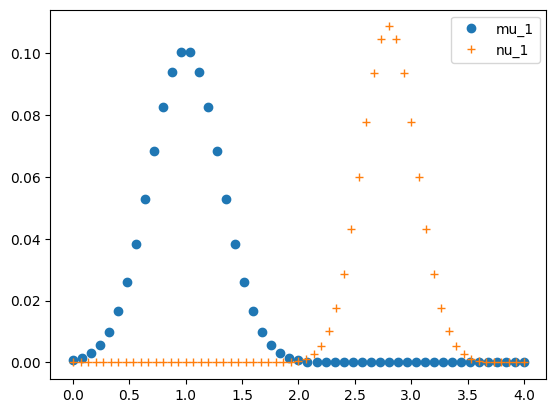

In [6]:
X_1 = np.linspace(0,4, 51)
Y_1 = np.linspace(0,4, 61)

def discrete_gaussian(mean, variance, interval):
    f = np.exp(-(interval-mean)**2/(2*variance)) / np.sqrt(2*np.pi*variance)
    return f/f.sum()

mu_1 = discrete_gaussian(1, 0.1, X_1)
nu_1 = discrete_gaussian(2.8, 0.06, Y_1)

'''Test measures'''

plt.figure(2)
plt.plot(X_1, mu_1, 'o', label="mu_1")
plt.plot(Y_1, nu_1, '+', label="nu_1")
plt.legend(loc=0)

'''Cost: Distance squared '''

C_1 = (X_1[:, None] - Y_1[None, :]) ** 2

## Machine Learning approach for computing OT:

The goal is to train a neural network that takes as input a pair of marginal distributions $\mu$ and $\nu$, and outputs the dual potentials $U$ and $V$ (discretized) that solve the entropically regularized dual OT problem.

### Problem Setup
We consider the regularized OT problem with $\varepsilon > 0$ and convex functions $\psi$.

$$\max \{ D^{\varepsilon}_C(u,v) = \sum_{i=0}^{n-1} u_i \mu_i + \sum_{j=n}^{m-1} v_j \nu_j - \varepsilon \sum_{i=0}^{n-1}\sum_{j=0}^{m-1} \psi({\frac{u_i+v_j - C_{ij}}{\varepsilon}}) \,:\, u\in \mathbb{R}^n,~ v\in \mathbb{R}^m\}$$

Instead of solving it via classical optimization, we learn an approximation by computing it with a DNN:

### Loss Function
The loss function can be chosen in several ways.
- `supervised` learning: pretrain some data with true solutions, and then use standard loss like MSE (we will not consider it today).
- `unsupervised` learning: choose as loss, for example, the (negative) dual functional $ L = -D(U, V)$ (sampled 1 from a batch) -- since we want to maximize it anyway!






In [7]:
# useful re-declaratons of some of functions in language of tensorflow


def tf_psi_0(x):
    return tf.exp(x)

def tf_psi_1(x):
    return tf.square(tf.math.maximum(x, tf.constant([0.])))

def tf_psi_2(x):
    return tf.math.log(tf.exp(x) + 1)

def tf_psi_0_prime(x):
    return tf.exp(x)

def tf_psi_1_prime(x):
    return tf.math.maximum(x, tf.constant([0.]))

def tf_psi_2_prime(x):
    return 1 /(tf.exp(-x) + 1)

def compute_U_V_C(U, V, C):
    """Calculates in appropriate dimensions along the batch:
    .. math::
        U_i \oplus V_j - C_ij

    """
    if len(U.shape) == 1:
        return U[:, None] + V[None, :] - C
    U_ = U[:, :, tf.newaxis]                # shape (n_samples, len(mu), 1)
    V_ = V[:, tf.newaxis, :]                # shape (n_samples, 1, len(nu))
    C_ = C[tf.newaxis, :, :]                # shape (1, len(mu), len(nu))
    U_V_C = U_ + V_ - C_
    return U_V_C

### Meta OT

In this [paper](https://arxiv.org/abs/2206.05262), the group of researchers in Meta proposed the following idea of using DNN for solving OT.

Particular choice of regularization:
- choose $\psi=exp$, and thus we know there are easy conditions for checking marginals and potentials explicitly
- the network needs only to predict one of potentials (e.g., `U`), and then compute the other one by the half-step of Sinkhorn:

      V = eps * log(nu) - eps * log(sum(exp((U[:, None] - C) / eps), axis=0))

(This can be simply extended to a multi-marginal setting as well: predict N-1 potentials, and compute the missing one)

In [75]:
"""Meta OT Network: possible implementation"""


class OT_Sinkhorn_network:
    """
    Builds a MetaOT model that maps (mu, nu) -> (U, V(U))
    Each of mu and nu has length `mu_len` and `nu_len` (e.g., (n,m))
    This network essentially predicts a good U, and then computes V = V(U)
    V(U) is computed via a half-Sinkhorn step

    loss:  ses loss function = -D(U, V(U))

    """
    def __init__(self, mu_len, nu_len, C, eps):
        self.mu_len = mu_len
        self.nu_len = nu_len
        self.C = C
        self.eps = eps

        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
        self.history = []

    def build_model(self):

        # Inputs: two marginals
        mu_input = Input(shape=(self.mu_len, ), name="mu")
        nu_input = Input(shape=(self.nu_len, ), name="nu")

        # Concatenate inputs
        x = Concatenate(name="concat")([mu_input, nu_input])

        hidden1 = Dense(64, activation='relu', kernel_initializer='zeros')(x)
        drop1 = Dropout(0.2)(hidden1)
        hidden2 = Dense(64, activation='relu', kernel_initializer='zeros')(drop1)
        hidden3 = Dense(64, activation='relu', kernel_initializer='zeros')(hidden2)
        drop2 = Dropout(0.1)(hidden3)

        # Two outputs: U and V (same shape as inputs)
        U_output = Dense(self.mu_len, name="U", kernel_initializer='zeros',
                         bias_initializer='zeros')(drop2)

        # V computed via entropic relation (half-step of Sinkhorn)
        V_output = Lambda(lambda x: self.compute_V(x[0], x[1]), name="V")([nu_input, U_output])

        model = Model(inputs=[mu_input, nu_input], outputs=[U_output, V_output])
        return model

    def compute_V(self, nu, U):
        U_ = U[:, :, tf.newaxis]
        C_ = self.C[tf.newaxis, :, :]
        nu_float = tf.cast(nu, tf.float32)

        V = tf.math.log(nu_float) - tf.math.log(tf.reduce_sum(tf.exp((U_ - C_)/self.eps), axis=1))
        return self.eps * V

    def dual(self, mu, nu): # quadratic_dual value on the batch
        U, V = self.model.call({"mu": tf.Variable(mu), "nu": tf.Variable(nu)})
        U_V_C = compute_U_V_C(U, V, self.C)
        P = tf.exp(U_V_C/ self.eps)
        D = - self.eps*tf.reduce_sum(P, axis=range(1,3))
        D += tf.reduce_sum(U*mu, axis=1)
        D += tf.reduce_sum(V*nu, axis=1)
        return D

    def loss(self, mu, nu):
        return  -tf.reduce_sum(self.dual(mu, nu))

    def train_step(self, mu, nu): #optimization step
        with tf.GradientTape() as tape: #assign loss function
            loss = self.loss(mu, nu)
        self.history.append(loss)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def fit(self, mu, nu, epochs=1000):
        for i in range(epochs):
            loss = self.train_step(mu, nu)

    def call(self, mu, nu):
        return self.model.call(({"mu": tf.Variable(mu), "nu": tf.Variable(nu)}))

    def predict_P(self, mu, nu):
        U, V = self.call(mu, nu)
        if len(U.shape) == 1:
            return np.exp((U[:, None] + V[None, :] - self.C) / self.eps)

        P = tf.exp(compute_U_V_C(U,V, self.C) / self.eps)
        return P

In [76]:
epsilon = 0.1
sink_model = OT_Sinkhorn_network(len(mu_1), len(nu_1), C_1, epsilon)

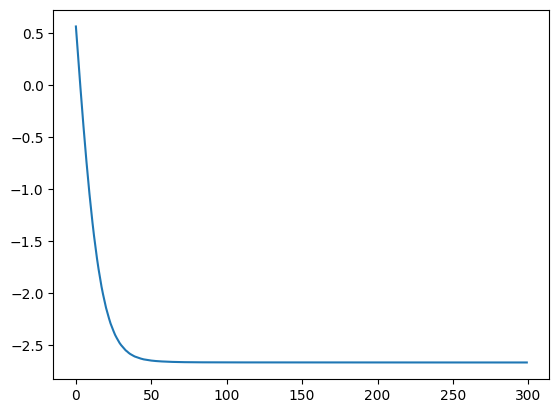

In [77]:
sink_model.fit(mu_1[None, :], nu_1[None, :], epochs=300)

P = sink_model.predict_P(mu_1[None, :], nu_1[None, :])[0]
plt.plot(sink_model.history)

Cost of P_computed: 3.2790878761339095
Cost of P_for_compare: 3.285080288241375


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.1)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

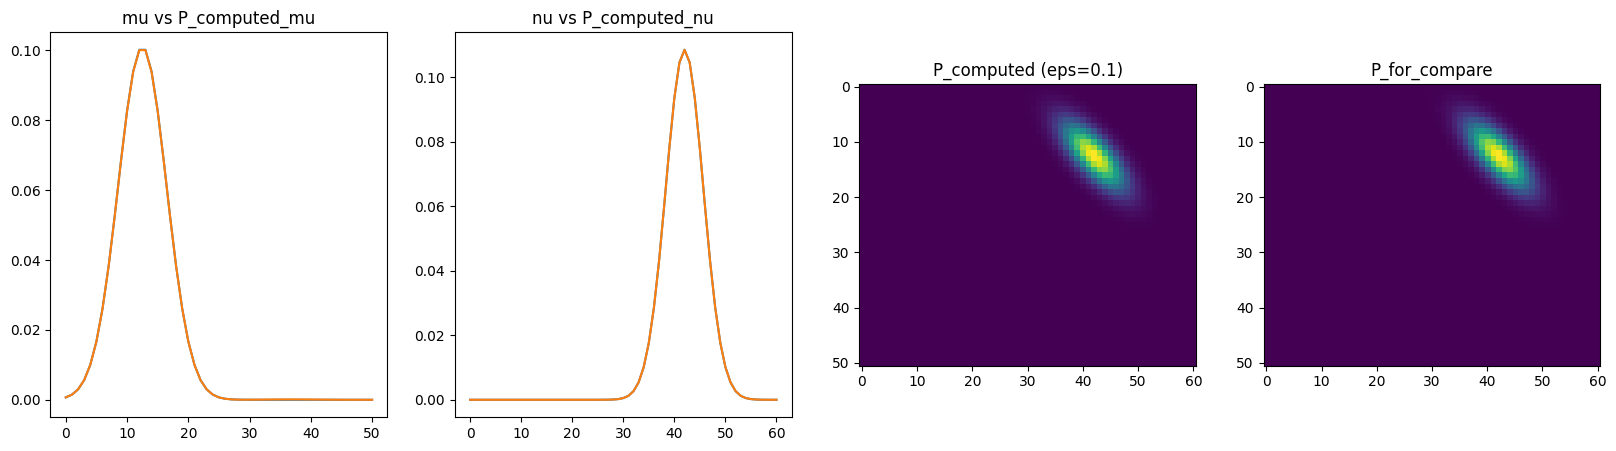

In [78]:
# to compare with
P_pot_sink = ot.sinkhorn(mu_1, nu_1, C_1, epsilon)

analyze_solutions(mu_1, nu_1, P, P_pot_sink, epsilon, C_1)

### Exercises:
- Try to understand the general approach, maybe do by-hand computations if needed
- Try to generate some more sample measures (you can see an example of generating a batch at ths bottom of tutorial) and try to train the network on several train measures. Do you think one needs to adapt and change the network architechture or maybe something with a loss functions?
- Play around with different pairs of measuses, values of `epsilon`, number of layers, different activation functions and so on -- you have a lot of freedom in this

In [79]:
"""Free space for experiments"""

'Free space for experiments'

## NN with general regularization

Let's now try to implement a network as described in the idea in the beginning of the tutorial

In [80]:
class OT_psi_network:
    """
    Builds a model that maps (mu, nu) -> (U, V)
    Each of mu and nu has length `mu_len` and `nu_len` (e.g., (n,m))
    """
    def __init__(self, mu_len, nu_len, C, eps, psi):
        self.mu_len = mu_len
        self.nu_len = nu_len
        self.C = C
        self.eps = eps
        self.psi = psi

        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
        self.history = []

    def build_model(self):

        # Inputs: two marginals
        mu_input = Input(shape=(self.mu_len, ), name="mu")
        nu_input = Input(shape=(self.nu_len, ), name="nu")

        # Concatenate inputs
        x = Concatenate(name="concat")([mu_input, nu_input])

        # Internal hidden layers
        hidden1 = Dense(64, activation='sigmoid', kernel_initializer='zeros')(x)
        drop1 = Dropout(0.2)(hidden1)
        hidden2 = Dense(64, activation='relu', kernel_initializer='zeros')(drop1)
        hidden3 = Dense(64, activation='relu', kernel_initializer='zeros')(hidden2)
        drop2 = Dropout(0.1)(hidden3)

        # Two outputs: U and V (same shape as inputs)
        U_output = Dense(self.mu_len, name="U", kernel_initializer='zeros',
                         bias_initializer='zeros')(drop2)
        V_output = Dense(self.nu_len, name="V", kernel_initializer='zeros',
                         bias_initializer='zeros')(drop2)

        model = Model(inputs=[mu_input, nu_input], outputs=[U_output, V_output])
        return model

    def psi_dual(self, mu, nu): # quadratic_dual value on the batch
        U, V = self.model.call({"mu": tf.Variable(mu), "nu": tf.Variable(nu)})
        U_V_C = compute_U_V_C(U, V, self.C)
        psi_U_V_C = self.psi(U_V_C/ self.eps)
        D = - self.eps*tf.reduce_sum(psi_U_V_C, axis=range(1,3))
        D += tf.reduce_sum(U*mu, axis=1)
        D += tf.reduce_sum(V*nu, axis=1)
        return D

    def loss(self, mu, nu):
        return  -tf.reduce_sum(self.psi_dual(mu, nu))

    def train_step(self, mu, nu, optimizer): #optimization step
        with tf.GradientTape() as tape: #assign loss function
            loss = self.loss(mu, nu)
        self.history.append(loss)

        grads = tape.gradient(loss, self.model.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def fit(self, mu, nu, epochs=1000, lr=0.05):
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        for i in range(epochs):
            loss = self.train_step(mu, nu, optimizer)

    def call(self, mu, nu):
        return self.model.call(({"mu": tf.Variable(mu), "nu": tf.Variable(nu)}))

    def predict_P(self, mu, nu, psi_prime):
        U, V = self.model.call({"mu": tf.Variable(mu), "nu": tf.Variable(nu)})
        P = psi_prime(compute_U_V_C(U, V, self.C) / self.eps)
        return P


psi_0

In [81]:
epsilon = 0.1
psi_model = OT_psi_network(len(mu_1), len(nu_1), C_1, epsilon, psi=tf_psi_0)

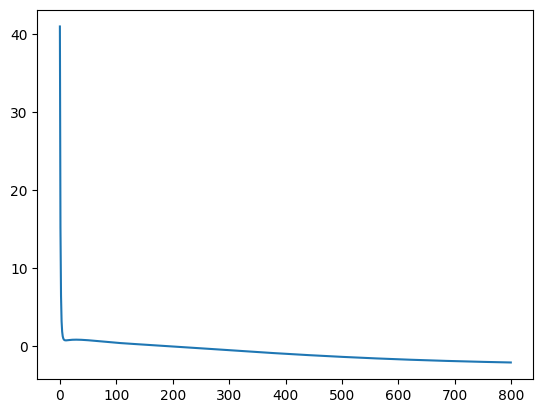

In [82]:
psi_model.fit(mu_1[None, :],nu_1[None, :], epochs=800)
P = psi_model.predict_P(mu_1[None, :], nu_1[None, :], tf_psi_0_prime)

plt.plot(psi_model.history)

Cost of P_computed: 1.633409068225002
Cost of P_for_compare: 3.285080288241375


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.1)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

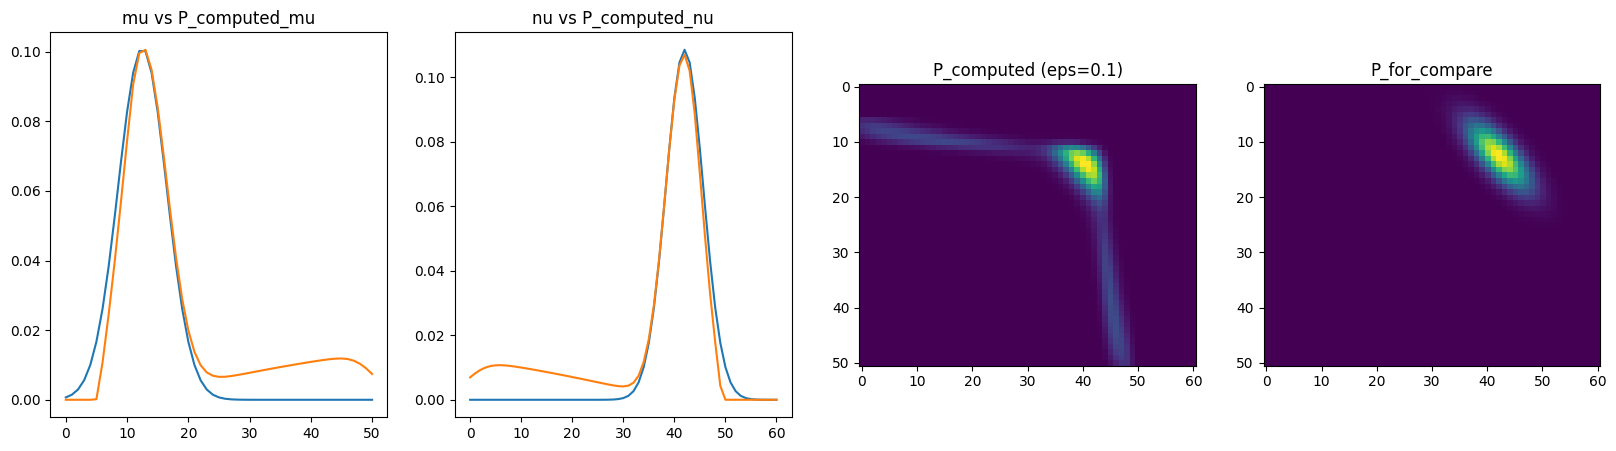

In [83]:
# to compare with
P_pot_sink = ot.sinkhorn(mu_1, nu_1, C_1, epsilon)

analyze_solutions(mu_1, nu_1, P[0], P_pot_sink, epsilon, C_1)

psi_1

In [84]:
epsilon = 0.1
psi_model = OT_psi_network(len(mu_1), len(nu_1), C_1, epsilon, psi=tf_psi_1)

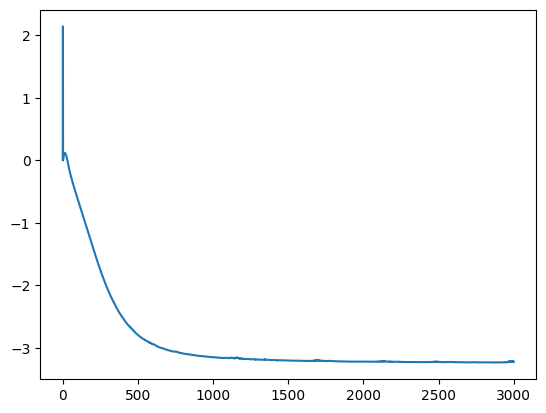

In [85]:
psi_model.fit(mu_1[None, :], nu_1[None, :], epochs=3000, lr=0.03)
P = psi_model.predict_P(mu_1[None, :], nu_1[None, :], tf_psi_1_prime)[0]

plt.plot(psi_model.history)

Cost of P_computed: 0.8445212978786892
Cost of P_for_compare: 3.285080288241375


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.1)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

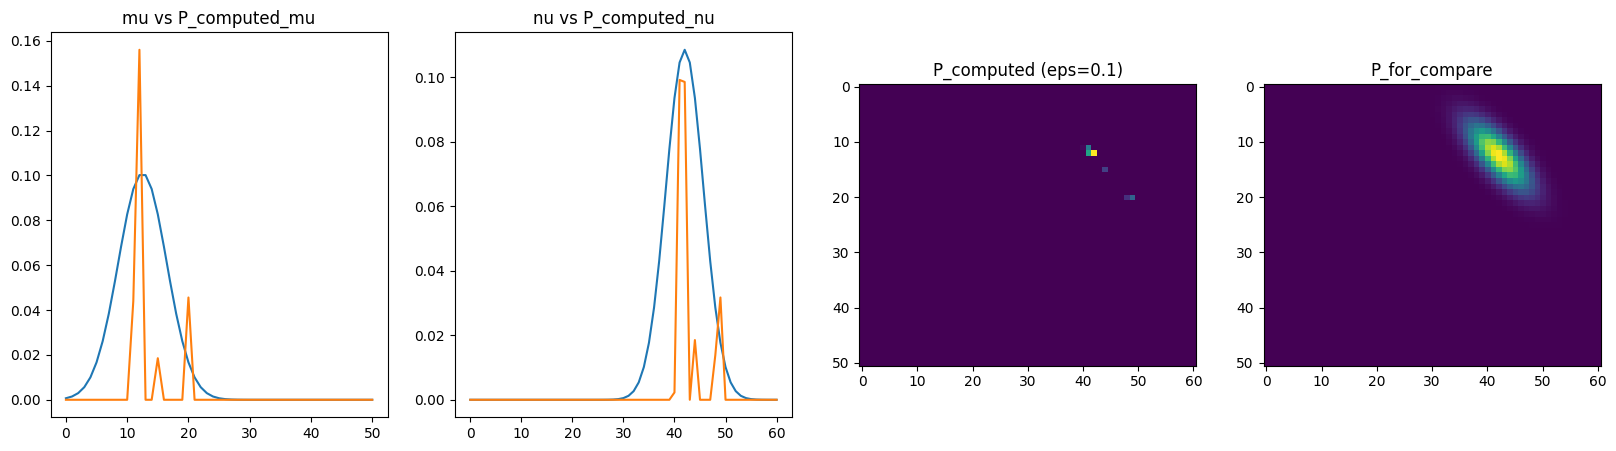

In [86]:
# to compare with
P_pot_sink = ot.sinkhorn(mu_1, nu_1, C_1, epsilon)

analyze_solutions(mu_1, nu_1, P, P_pot_sink, epsilon, C_1)

psi_2

In [87]:
epsilon = 0.01
psi_model = OT_psi_network(len(mu_1), len(nu_1), C_1, epsilon, psi=tf_psi_2)

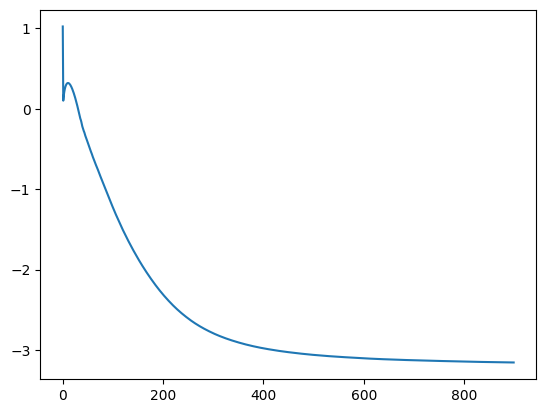

In [88]:
psi_model.fit(mu_1[None, :], nu_1[None, :], epochs=900, lr=0.05)
P = psi_model.predict_P(mu_1[None, :], nu_1[None, :], tf_psi_2_prime)[0]

plt.plot(psi_model.history)

Cost of P_computed: 3.061798760497555
Cost of P_for_compare: 3.247895419559598


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.01)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

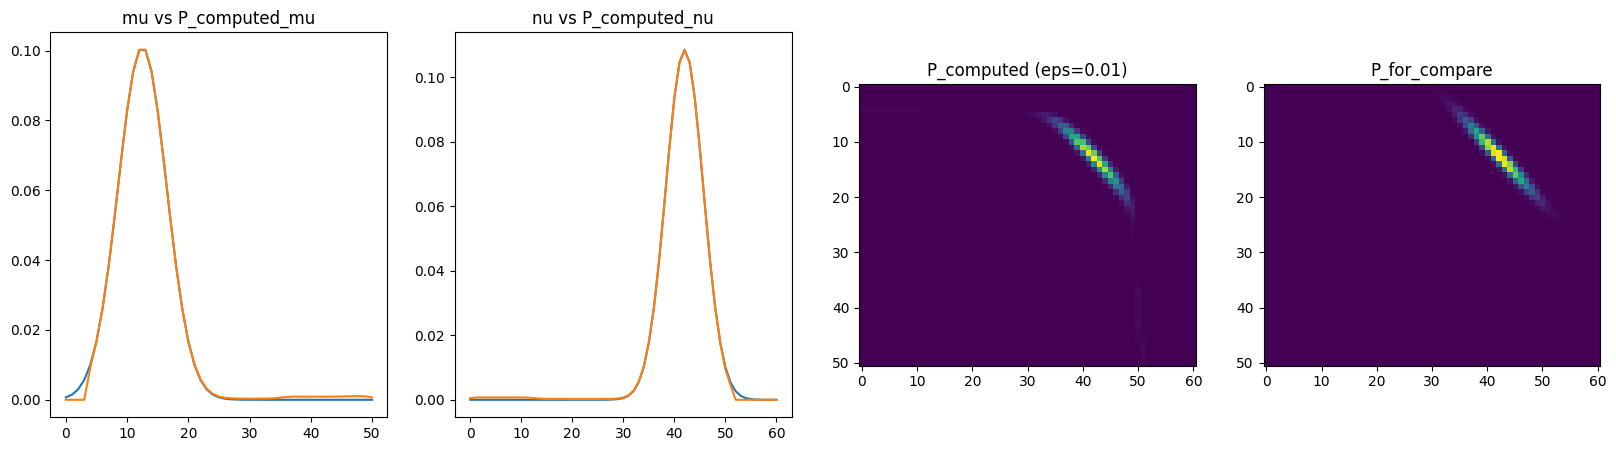

In [89]:
# to compare with
P_pot_sink = ot.sinkhorn(mu_1, nu_1, C_1, epsilon)

analyze_solutions(mu_1, nu_1, P, P_pot_sink, epsilon, C_1)

### Exercises:
- (As you may guess) Try to experiment with a different number of epochs, learning rates, etc
- (Advanced) try to implement some sort of a simulation of a half-sinkhorn to imitate the idea of MetaOT, e.g. estimate only `U` and then compute `V` as some approximation of $argmax \{D(U, \cdot)\}$ by a lambda layer -- you can even write a separate NN to estimate best V from (mu, nu, U), or directly with some nested gradient method. (Talk to me if interested)

In [90]:
"""Free space for experiments"""

'Free space for experiments'

## What happens if we change a loss function and concentrate more on finding the "satisfying marginal constraints"

Let's not try to write a network that will predict (`U`, `V`) with the condition that the marginals must be satisfied.

We know that the optimal plan `P` must be of a form
$$P_{ij} = \psi'({\frac{u_i+v_j - C_{ij}}{\varepsilon}})$$

Then we can then also try to choose a loss of a form
$$L = \sum_i||\mu_i-\sum_j P_{ij}||^2 + \sum_j||\nu_j-\sum_i P_{ij}||^2$$

Question: How well does it actually perform?

In [178]:
class OT_psi_marginal_network:
    """
    Builds a model that maps (mu, nu) -> (U, V)
    Each of mu and nu has length `mu_len` and `nu_len` (e.g., (n,m))
    Uses loss - error of marginals
    """
    def __init__(self, mu_len, nu_len, C, eps, psi_prime, lr=0.05):
        self.mu_len = mu_len
        self.nu_len = nu_len
        self.C = C
        self.eps = eps
        self.psi_prime = psi_prime

        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
        self.history = []

    def build_model(self):

        # Inputs: two marginals
        mu_input = Input(shape=(self.mu_len, ), name="mu")
        nu_input = Input(shape=(self.nu_len, ), name="nu")

        # Concatenate inputs
        x = Concatenate(name="concat")([mu_input, nu_input])

        hiddens_u = [x, ]
        hiddens_v = [x, ]

        for i in range(10):
            hiddens_u.append(
                # Dense(64, activation='relu', kernel_initializer='zeros')(hiddens_u[-1])
                Dense(64, activation='tanh', kernel_initializer='zeros')(hiddens_u[-1])
            )
            hiddens_u.append(Dropout(0.2)(hiddens_u[-1]))

            hiddens_v.append(
                # Dense(64, activation='relu', kernel_initializer='zeros')(hiddens_v[-1])
                Dense(64, activation='tanh', kernel_initializer='zeros')(hiddens_v[-1])
            )
            hiddens_v.append(Dropout(0.2)(hiddens_v[-1]))

        # Two outputs: U and V (same shape as inputs)
        U_output = Dense(self.mu_len, name="U", kernel_initializer='zeros',
                         bias_initializer='zeros')(hiddens_u[-1])
        V_output = Dense(self.nu_len, name="V", kernel_initializer='zeros',
                         bias_initializer='zeros')(hiddens_v[-1])

        model = Model(inputs=[mu_input, nu_input], outputs=[U_output, V_output])
        return model

    def marginal_loss(self, mu, nu):
        P = self.predict_P(mu, nu)
        P_x = tf.reduce_sum(P, axis=2)
        P_y = tf.reduce_sum(P, axis=1)

        l = tf.reduce_sum(tf.square(mu - P_x))
        l += tf.reduce_sum(tf.square(nu - P_y))
        return l

    def train_step(self, mu, nu): #optimization step
        with tf.GradientTape() as tape: #assign loss function
            loss = self.marginal_loss(mu, nu)
        self.history.append(loss)
        print(loss)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def fit(self, mu, nu, epochs=1000):
        for i in range(epochs):
            loss = self.train_step(mu, nu)

    def call(self, mu, nu):
        return self.model.call(({"mu": tf.Variable(mu), "nu": tf.Variable(nu)}))

    def predict_P(self, mu, nu):
        U, V = self.model.call({"mu": tf.Variable(mu), "nu": tf.Variable(nu)})
        P = self.psi_prime(self.compute_U_V_C(U,V, self.C) / self.eps)
        return P

    def compute_U_V_C(self, U, V, C):
        """Calculates in appropriate dimensions along the batch:
        .. math::
            U_i \oplus V_j - C_ij

        """
        if len(U.shape) == 1:
            return U[:, None] + V[None, :] - C
        U_ = U[:, :, tf.newaxis]                # shape (n_samples, len(mu), 1)
        V_ = V[:, tf.newaxis, :]                # shape (n_samples, 1, len(nu))
        C_ = C[tf.newaxis, :, :]                # shape (1, len(mu), len(nu))
        U_V_C = U_ + V_ - C_
        return U_V_C

In [179]:
epsilon = 0.1
test_model = OT_psi_marginal_network(len(mu_1), len(nu_1), C_1, epsilon, tf_psi_0_prime, lr=0.01)

In [180]:
test_model.fit(mu_1[None, :],nu_1[None, :],epochs=10_000)

P_pred = test_model.predict_P(mu_1[None, :], nu_1[None, :])
plt.figure()
plt.plot(test_model.history[10:])

tf.Tensor(6077.2476, shape=(), dtype=float32)
tf.Tensor(4069.1836, shape=(), dtype=float32)
tf.Tensor(2755.9697, shape=(), dtype=float32)
tf.Tensor(1898.6595, shape=(), dtype=float32)
tf.Tensor(1335.1847, shape=(), dtype=float32)
tf.Tensor(960.01355, shape=(), dtype=float32)
tf.Tensor(705.99927, shape=(), dtype=float32)
tf.Tensor(530.7718, shape=(), dtype=float32)
tf.Tensor(407.53284, shape=(), dtype=float32)
tf.Tensor(319.18134, shape=(), dtype=float32)
tf.Tensor(254.65944, shape=(), dtype=float32)
tf.Tensor(206.70644, shape=(), dtype=float32)
tf.Tensor(170.47568, shape=(), dtype=float32)
tf.Tensor(142.67776, shape=(), dtype=float32)
tf.Tensor(121.043304, shape=(), dtype=float32)
tf.Tensor(103.98151, shape=(), dtype=float32)
tf.Tensor(90.36021, shape=(), dtype=float32)
tf.Tensor(79.36188, shape=(), dtype=float32)
tf.Tensor(70.38805, shape=(), dtype=float32)
tf.Tensor(62.99492, shape=(), dtype=float32)
tf.Tensor(56.84931, shape=(), dtype=float32)
tf.Tensor(51.69823, shape=(), dtype=flo

KeyboardInterrupt: 

Cost of P_computed: 0.06467231963670865
Cost of P_for_compare: 3.285080288241375


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.1)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

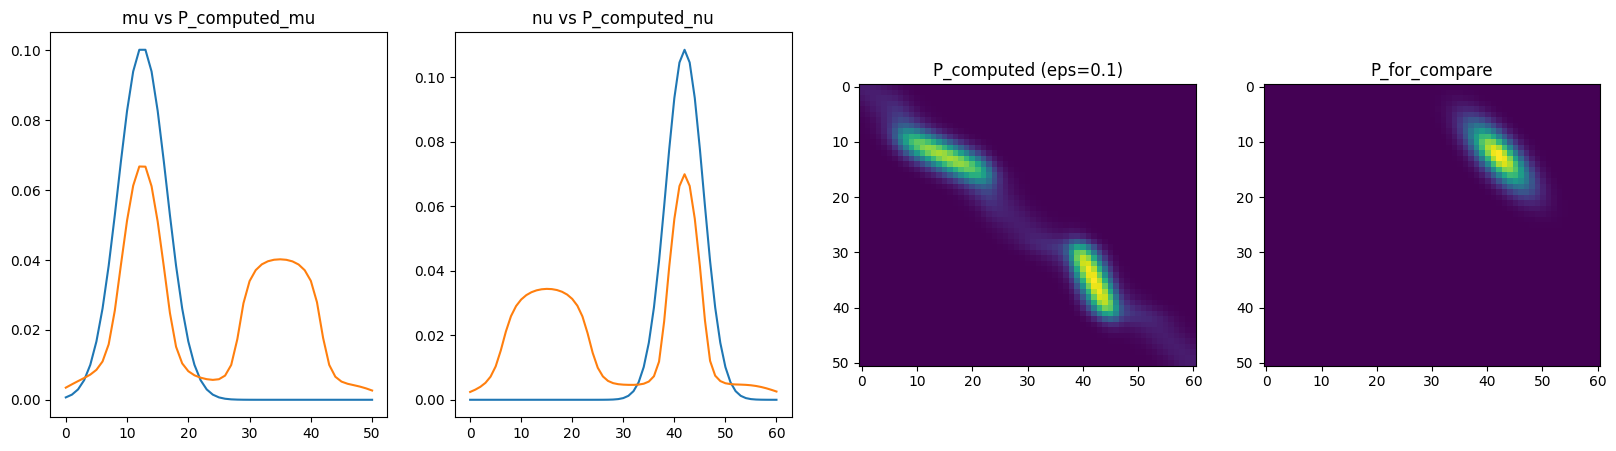

In [181]:
# to compare with
P_pot_sink = ot.sinkhorn(mu_1, nu_1, C_1, epsilon)

analyze_solutions(mu_1, nu_1, P_pred[0], P_pot_sink, epsilon, C_1)

In [182]:
P = P_pred

mu, nu = mu_1[None, :],nu_1[None, :]

P_x = tf.reduce_sum(P, axis=2)
P_y = tf.reduce_sum(P, axis=1)

l = tf.reduce_sum(tf.square(mu - P_x))
l += tf.reduce_sum(tf.square(nu - P_y))
print(l)

tf.Tensor(0.062696815, shape=(), dtype=float32)


In [183]:
P = P_pot_sink[tf.newaxis, :, :]

mu, nu = mu_1[None, :],nu_1[None, :]

P_x = tf.reduce_sum(P, axis=2)
P_y = tf.reduce_sum(P, axis=1)

l = tf.reduce_sum(tf.square(mu - P_x))
l += tf.reduce_sum(tf.square(nu - P_y))
print(l)

tf.Tensor(4.9173173072582296e-23, shape=(), dtype=float64)


psi_1 maybe?

In [28]:
epsilon = 0.1
test_model = OT_psi_marginal_network(len(mu_1), len(nu_1), C_1, epsilon, tf_psi_1_prime)

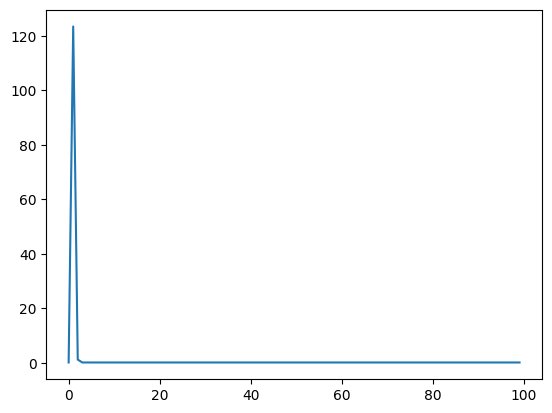

In [29]:
test_model.fit(mu_1[None, :],nu_1[None, :],epochs=100)

P = test_model.predict_P(mu_1[None, :], nu_1[None, :])
plt.figure()
plt.plot(test_model.history)

In [30]:
test_model.history[-5:]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.14821103>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.14821103>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.14821103>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.14821103>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.14821103>]

Cost of P_computed: 0.0
Cost of P_for_compare: 3.285080288241375


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.1)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

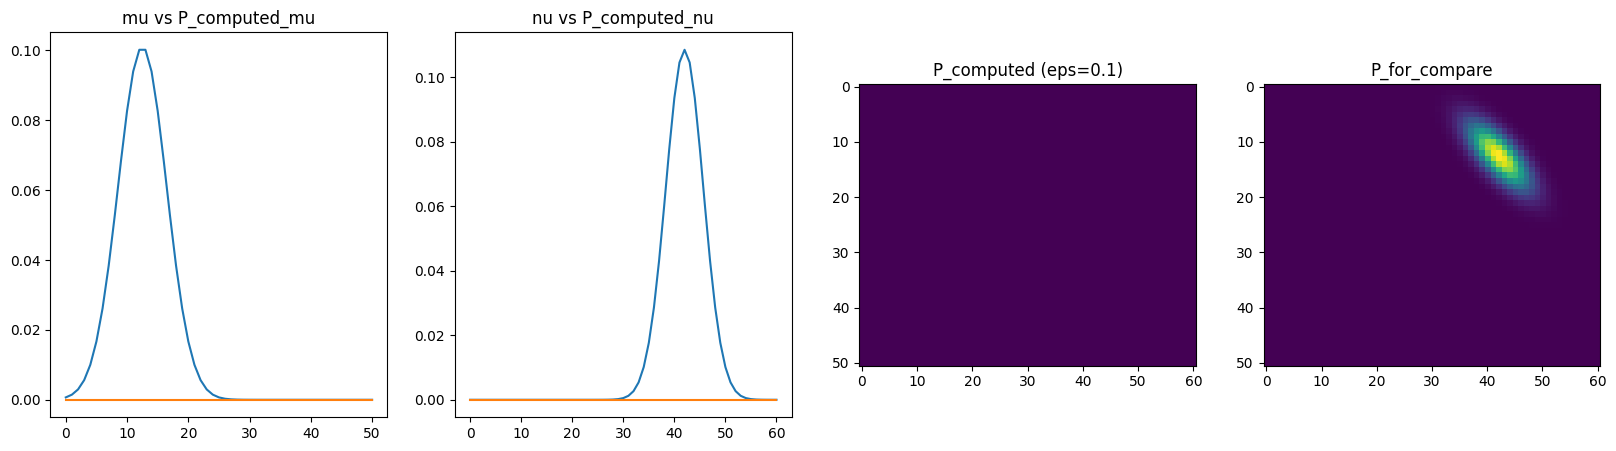

In [31]:
# to compare with
P_pot_sink = ot.sinkhorn(mu_1, nu_1, C_1, epsilon)

analyze_solutions(mu_1, nu_1, P[0], P_pot_sink, epsilon, C_1)

psi_2 last chance?

In [32]:
epsilon = 0.1
test_model = OT_psi_marginal_network(len(mu_1), len(nu_1), C_1, epsilon, tf_psi_2_prime)

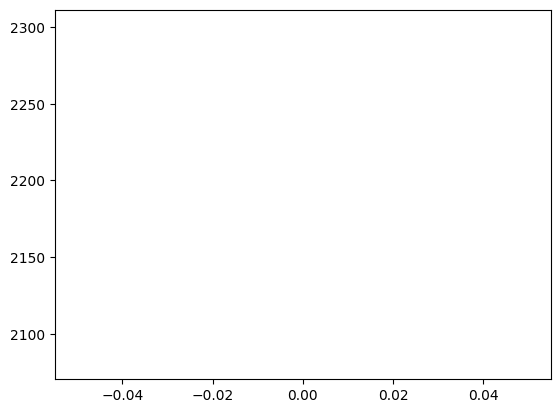

In [33]:
test_model.fit(mu_1[None, :],nu_1[None, :],epochs=100)

P = test_model.predict_P(mu_1[None, :], nu_1[None, :])
plt.figure()
plt.plot(test_model.history)

In [34]:
test_model.history[-5:]

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>]

Cost of P_computed: nan
Cost of P_for_compare: 3.285080288241375


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.1)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

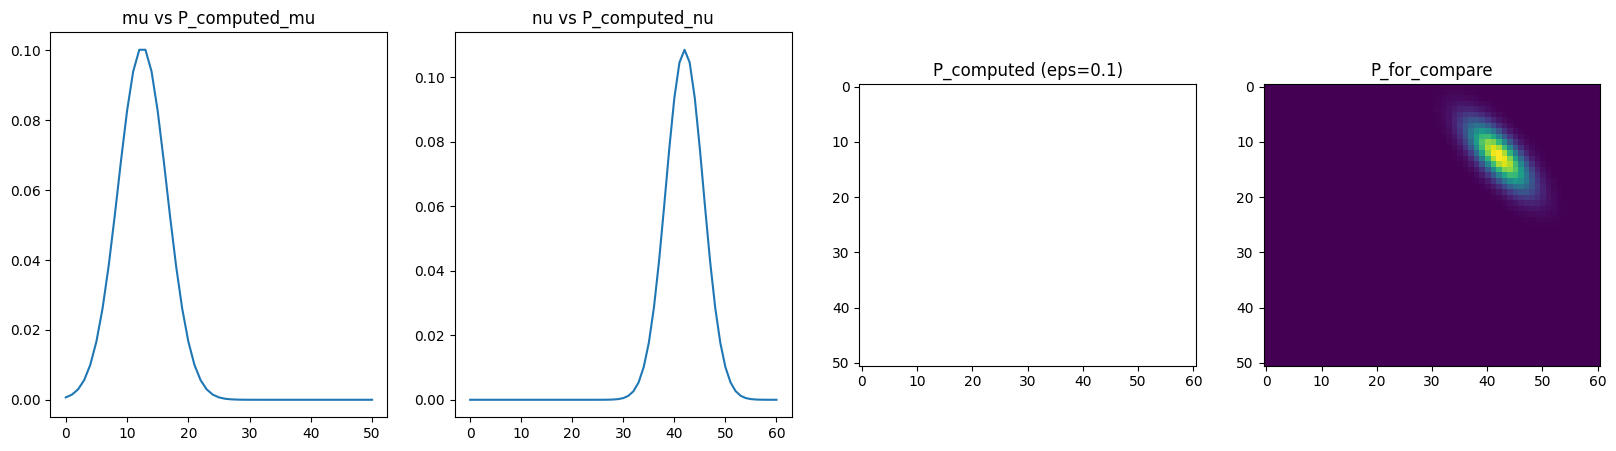

In [35]:
# to compare with
P_pot_sink = ot.sinkhorn(mu_1, nu_1, C_1, epsilon)

analyze_solutions(mu_1, nu_1, P[0], P_pot_sink, epsilon, C_1)

As you may have observed, the performance of this loss function is not so good, why do you think so? (Talk to me)

----
# Time-consuming (optional) exercise

Motivation: For entropy regularized OT, we know that for $(U,V)$ to be the maximizers of the dual problem, the following conditions must be satisfied:
$$
\begin{cases}
\mu_i = \sum_{j}\exp(\frac{U_i + V_j - C_{ij}}{\varepsilon}) & \forall i\\
\nu_j = \sum_{i}\exp(\frac{U_i + V_j - C_{ij}}{\varepsilon}) & \forall j
\end{cases}
$$
or, equivalently
$$
\begin{cases}
U_i = \varepsilon(\log \mu_i - \log \sum_{j} \exp(\frac{V_j - C_{ij}}{\varepsilon})) & \forall i\\
V_j = \varepsilon(\log \nu_j - \log \sum_{i} \exp(\frac{U_i - C_{ij}}{\varepsilon})) & \forall j
\end{cases}
$$

### Then try to implement the following idea:
Fix some domains $X = \{x_1,...,x_N\}$ and $Y = \{y_1, ..., y_M\}$ and compute a cost $C_{ij} = c(x_i, y_j)$ for some chosen cost function $c$, and choose $\varepsilon >0$. Now:

1. Generate $K$ samples of measures $\mu^1, ..., \mu^K$, e.g., as some gaussians or mixed gaussians (example of code below)
2. Generate also $K$ potentials $V^1, ..., V^K$, e.g., some "gaussians", "radial decays" and so on
3. For each $k=1,...,K$ compute
$$
U^k_i = \varepsilon(\log \mu^k_i - \log \sum_{j} \exp(\frac{V^k_j - C_{ij}}{\varepsilon}))
$$
4. For each $k=1,...,K$ compute
$$\nu^k_j = \sum_{i}\exp(\frac{U^k_i + V^k_j - C_{ij}}{\varepsilon})
$$

This way, we have generated a dataset of pairs of measures $(\mu^k, \nu^k)$ and corresponding $(U^k, V^k)$ which are in fact the solutions of the OT problems.

Now, use this dataset for training a `supervised` Neural Network that takes as input $(\mu, \nu)$ and outputs $(U,V)$ which are the estimates for solutions of $OT_\varepsilon(\mu,\nu)$. In this case, one can also use as loss MSE, or a mix of MSE and Dual formula loss (e.g., evaluation of some $-D_\varepsilon(U_{sample}, V_{sample}$)).

*(In the code snippets below, you are free to modify all the definitions and models of your `mu`'s and `V`'s, I am just adding a possible idea. I generally suggest that your potential $V$ should be decaying fast outside of some small regions (Ask me why if needed). You can plot your obtained missing `U`'s and `nu`'s and also `P`'s to see if your test samples are actually meaningful.)*

------

Have fun!


In [ ]:
"""Example of a way to generate some test measures"""

# generating some samples of measures (we will generate gaussian mixtures)
# we will consider them all on the same domain
low = -5
high = 5
n_discretization = 51
interval = np.linspace(low, high, n_discretization)
C1 = (interval[:, None] - interval[None, :])**2
C1 /= np.sum(C1) # to control the values
border_percent = 0.1 # make sure that mean of gaussians are a bit away from corners of the interval
border_value = border_percent * (high - low)
n_samples_per_mix = 20 # number of elements in gaussian mixture


def gaussian_mixture(means, variances, interval):
    mix_many = np.exp(-(interval[None, None, :]-means[:,:,None])**2/(2*variances[:,:,None])) / np.sqrt(2*np.pi*variances[:,:,None])
    mix = np.sum(mix_many, axis=1)
    return mix / (np.sum(mix, axis=1)[:, None])

def radial_mixture(centers, rates, interval):
    mix_many = np.exp(-rates[:, :, None] * np.abs(interval[None, None, :]-centers[:,:,None]))
    mix = np.sum(mix_many, axis=1)
    return mix / (np.sum(mix, axis=1)[:, None])


mu_samples = []
for i in range(1,6):
    np.random.seed(i)
    means = np.random.uniform(low + border_value, high - border_value, (n_samples_per_mix, i))
    variances = np.random.uniform(0.05, 0.5, (n_samples_per_mix, i))
    mu_samples.append(gaussian_mixture(means, variances, interval))

mu_samples = np.vstack(mu_samples)

np.random.seed(1)
np.random.shuffle(mu_samples)

V_samples = []
for i in range(1,2): # i.e. gaussian-looking
    np.random.seed(2*i)
    means = np.random.uniform(low + border_value, high - border_value, (n_samples_per_mix, i))
    variances = np.random.uniform(0.01, 0.5, (n_samples_per_mix, i))
    V_samples.append(gaussian_mixture(means, variances, interval))

for i in range(1,5): # i.e. radial decay
    np.random.seed(3*i)
    centers = np.random.uniform(low + border_value, high - border_value, (n_samples_per_mix, i))
    rates = np.random.uniform(0.1, 1, (n_samples_per_mix, i))
    V_samples.append(radial_mixture(centers, rates, interval))

V_samples = np.vstack(V_samples)

In [ ]:
eps = 0.001

K1 = np.exp(- C1 / (eps * np.max(C1)))
P_u_j = np.exp((V_samples[:, None, :])/ eps) * K1[None, :, :]

U_samples = eps * np.log(mu_samples) - eps * np.log(np.sum(P_u_j, axis=2))

P_samples = np.exp((U_samples[:, :, None] + V_samples[:, None, :])/ eps) * K1[None, :, :]
nu_samples = np.sum(P_samples, axis=1)


In [ ]:
plt.plot(interval, V_samples[-20:].T)

In [ ]:
# taking a look at one of the sample problems and solutions
idx = 95
plt.figure()
# OT-eps plan
ot.plot.plot1D_mat(mu_samples[idx], nu_samples[idx], P_samples[idx])
plt.figure()
# compared to product measure
ot.plot.plot1D_mat(mu_samples[idx], nu_samples[idx], mu_samples[idx, :, None]*nu_samples[idx, None, :])

In [ ]:
plt.plot(V_samples[idx])

In [ ]:
"""Work on your Neural Network here"""